In [4]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 加载数据集
train = pd.read_csv('data/sales_train_v2.csv')
test = pd.read_csv('data/test.csv')
shop = pd.read_csv('data/shops.csv')
item = pd.read_csv('data/items.csv')
items_categories = pd.read_csv('data/item_categories.csv')

In [6]:
# 查看数据集大小
print("""
         训练集shape={}
         测试集shape={}
         shop的shape={}
         item的shape={}
         item_categories的shape{}""".format(train.shape,test.shape,shop.shape,item.shape,items_categories.shape))


         训练集shape=(2935849, 6)
         测试集shape=(214200, 3)
         shop的shape=(60, 2)
         item的shape=(22170, 3)
         item_categories的shape(84, 2)


# 对于train数据集的分析
- date 表示日期
- date_block_num 用来标记月份，2013年1月是0，2015年10月是33
- shop_id 用来表示那一个商店，一共有60个商店，商店的具体名称见shop.csv文件
- item_id 商品的ID，一共有22170种商品，见items.csv
- item_categories_id 商品类别ID，一共有84个商品类别,见items_categories.csv文件
- item_price 价格
- item_cnt_day 销售产品的数量

In [7]:
train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
# date为字符串类型，剩下都是int或者float类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
# 数据没有空值
tmp = train.isnull().sum()
tmp[tmp>0]

Series([], dtype: int64)

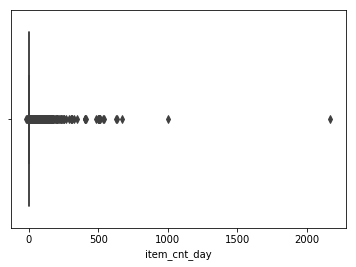

In [10]:
# 查看销售数目的箱图
sns.boxplot(train.item_cnt_day)

In [11]:
len(train[train['item_cnt_day']>200])

38

In [12]:
len(train[train['item_cnt_day']<0])

7356

In [13]:
# 先删除每日销售中的异常点，大于200件的为38，小于0的为7356,总共删除7394,约占0.2%
train = train[train.item_cnt_day<200]
train = train[train.item_cnt_day>0]

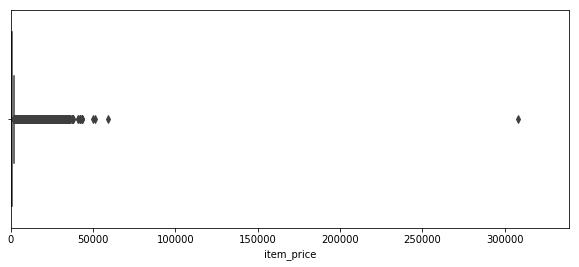

In [14]:
plt.figure(figsize=(10,4))#图的大小
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)#最大值乘以1.1
sns.boxplot(x=train.item_price)#自变量
plt.show()

In [15]:
len(train[train['item_price']>50000])

3

In [16]:
len(train[train['item_price']<1])

4653

In [17]:
##再对产品的销售价格进行修改,商品价格大于50000的为3，价格小于1的为4653
train = train[train.item_price<50000]
train = train[train.item_price>1]

In [18]:
train.shape

(2923797, 6)

In [19]:
# 改变日期格式
train['date'] = pd.to_datetime(train['date'],format='%d.%m.%Y')

# 数据处理

In [20]:
# 将数据按照月分组
data = train.groupby([train['date'].apply(lambda x:x.strftime('%Y.%m')),'item_id','shop_id']).sum().reset_index()

In [21]:
data.head(5)

,date,item_id,shop_id,date_block_num,item_price,item_cnt_day
0,2013.01,19,25,0,28.0,1.0
1,2013.01,27,1,0,1890.0,1.0
2,2013.01,27,2,0,2499.0,1.0
3,2013.01,27,10,0,1890.0,1.0
4,2013.01,27,19,0,2499.0,1.0


In [22]:
# 选取特定的列
data = data[['date','item_id','shop_id','item_cnt_day']]

In [23]:
data.head(5)

,date,item_id,shop_id,item_cnt_day
0,2013.01,19,25,1.0
1,2013.01,27,1,1.0
2,2013.01,27,2,1.0
3,2013.01,27,10,1.0
4,2013.01,27,19,1.0


In [24]:
data = data.pivot_table(index=['item_id','shop_id'], columns = 'date', values = 'item_cnt_day', fill_value = 0).reset_index()

In [25]:
data.head(5)

date,item_id,shop_id,2013.01,2013.02,2013.03,2013.04,2013.05,2013.06,2013.07,2013.08,...,2015.01,2015.02,2015.03,2015.04,2015.05,2015.06,2015.07,2015.08,2015.09,2015.10
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data.shape

(423679, 36)

In [27]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [28]:
test = pd.merge(test, data, on = ['item_id', 'shop_id'], how = 'left')

In [29]:
test.head(5)

,ID,shop_id,item_id,2013.01,2013.02,2013.03,2013.04,2013.05,2013.06,2013.07,...,2015.01,2015.02,2015.03,2015.04,2015.05,2015.06,2015.07,2015.08,2015.09,2015.10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
test.fillna(0,inplace=True)

In [34]:
test.head(5)

,ID,shop_id,item_id,2013.01,2013.02,2013.03,2013.04,2013.05,2013.06,2013.07,...,2015.01,2015.02,2015.03,2015.04,2015.05,2015.06,2015.07,2015.08,2015.09,2015.10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 模型训练

In [37]:
# 创建训练集
x_train = test.drop(['2015.10', 'item_id', 'shop_id'], axis = 1)
y_train = test['2015.10']
# 创建测试集
x_test = test.drop(['2013.01', 'item_id', 'shop_id'], axis = 1)

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(x_train, y_train)
mode2 = GBR.predict(x_test).clip(0,20)

In [39]:
mode2=pd.DataFrame(mode2,columns=['item_cnt_month'])
mode2.to_csv('submission.csv',index_label='ID')